In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import sqlalchemy as sqla
df_nArticlesPerUser = pd.read_pickle("250_posts_data.pkl")

In [2]:
df_nArticlesPerUser

,ID_User,Beitrag
0,28526,Man kann es auch mal umgekehrt betrachten. Sch...
1,28526,Die US-Primaries sind jedenfalls für mich der ...
2,28526,vielleicht bin ich da noch etwas zu traditione...
3,28526,Interessant ist allerdings das er offenbar die...
4,28526,Schweden ist möglicherweise das merkwürdigste ...
...,...,...
4995,18006,"""Sie versuchte aber auch einen ursprünglichen ..."
4996,18006,Wehrpflicht ist schon ein guter Ansatz :-)IÜ s...
4997,18006,"Trotz der geplatzten IT-Blase, die Bush von Cl..."
4998,18006,Griechenland hat schon sehr üble Tricks um die...


In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df=15)
features = tfidf.fit_transform(df_nArticlesPerUser.Beitrag).toarray()
labels = df_nArticlesPerUser.ID_User
features.shape

(5000, 2238)

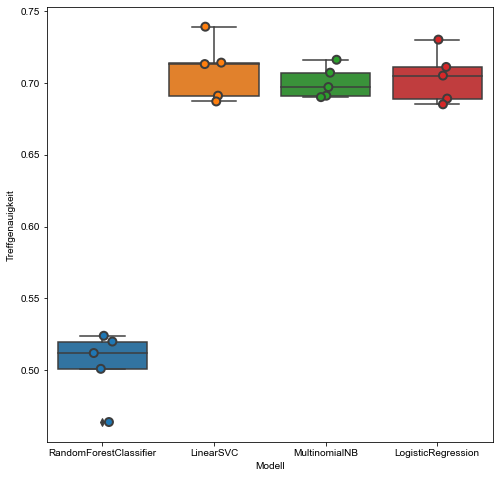

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
import seaborn as sns

models = [
RandomForestClassifier(n_estimators=100),
LinearSVC(),
MultinomialNB(),
LogisticRegression(),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy',cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

plt.figure(figsize=(8,8))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=8, jitter=True, edgecolor="gray", linewidth=2)
sns.set(rc={"figure.figsize":(3, 4)})
plt.xlabel('Modell')
plt.ylabel('Treffgenauigkeit')
plt.show()

In [5]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.7088
LogisticRegression        0.7040
MultinomialNB             0.7002
RandomForestClassifier    0.5042
Name: accuracy, dtype: float64

In [6]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.512
1,RandomForestClassifier,1,0.464
2,RandomForestClassifier,2,0.524
3,RandomForestClassifier,3,0.501
4,RandomForestClassifier,4,0.520
5,LinearSVC,0,0.714
6,LinearSVC,1,0.691
7,LinearSVC,2,0.739
8,LinearSVC,3,0.713
9,LinearSVC,4,0.687


In [11]:
from pandas.io.formats.style import Styler
print(pd.DataFrame(cv_df).style.to_latex(label='tab:table1', caption='Tabelle', clines='all;data'))

\begin{table}
\caption{Tabelle}
\label{tab:table1}
\begin{tabular}{llrr}
 & model_name & fold_idx & accuracy \\
0 & RandomForestClassifier & 0 & 0.512000 \\
\cline{1-4}
1 & RandomForestClassifier & 1 & 0.464000 \\
\cline{1-4}
2 & RandomForestClassifier & 2 & 0.524000 \\
\cline{1-4}
3 & RandomForestClassifier & 3 & 0.501000 \\
\cline{1-4}
4 & RandomForestClassifier & 4 & 0.520000 \\
\cline{1-4}
5 & LinearSVC & 0 & 0.714000 \\
\cline{1-4}
6 & LinearSVC & 1 & 0.691000 \\
\cline{1-4}
7 & LinearSVC & 2 & 0.739000 \\
\cline{1-4}
8 & LinearSVC & 3 & 0.713000 \\
\cline{1-4}
9 & LinearSVC & 4 & 0.687000 \\
\cline{1-4}
10 & MultinomialNB & 0 & 0.707000 \\
\cline{1-4}
11 & MultinomialNB & 1 & 0.691000 \\
\cline{1-4}
12 & MultinomialNB & 2 & 0.716000 \\
\cline{1-4}
13 & MultinomialNB & 3 & 0.697000 \\
\cline{1-4}
14 & MultinomialNB & 4 & 0.690000 \\
\cline{1-4}
15 & LogisticRegression & 0 & 0.711000 \\
\cline{1-4}
16 & LogisticRegression & 1 & 0.689000 \\
\cline{1-4}
17 & LogisticRegression & 2 & 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

entries = []
for model in models:
    model_name = model.__class__.__name__
    X_train, X_test, y_train, y_test =train_test_split(features, labels, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    matrix = confusion_matrix(y_test, y_pred)
    entries.append((model_name, matrix))

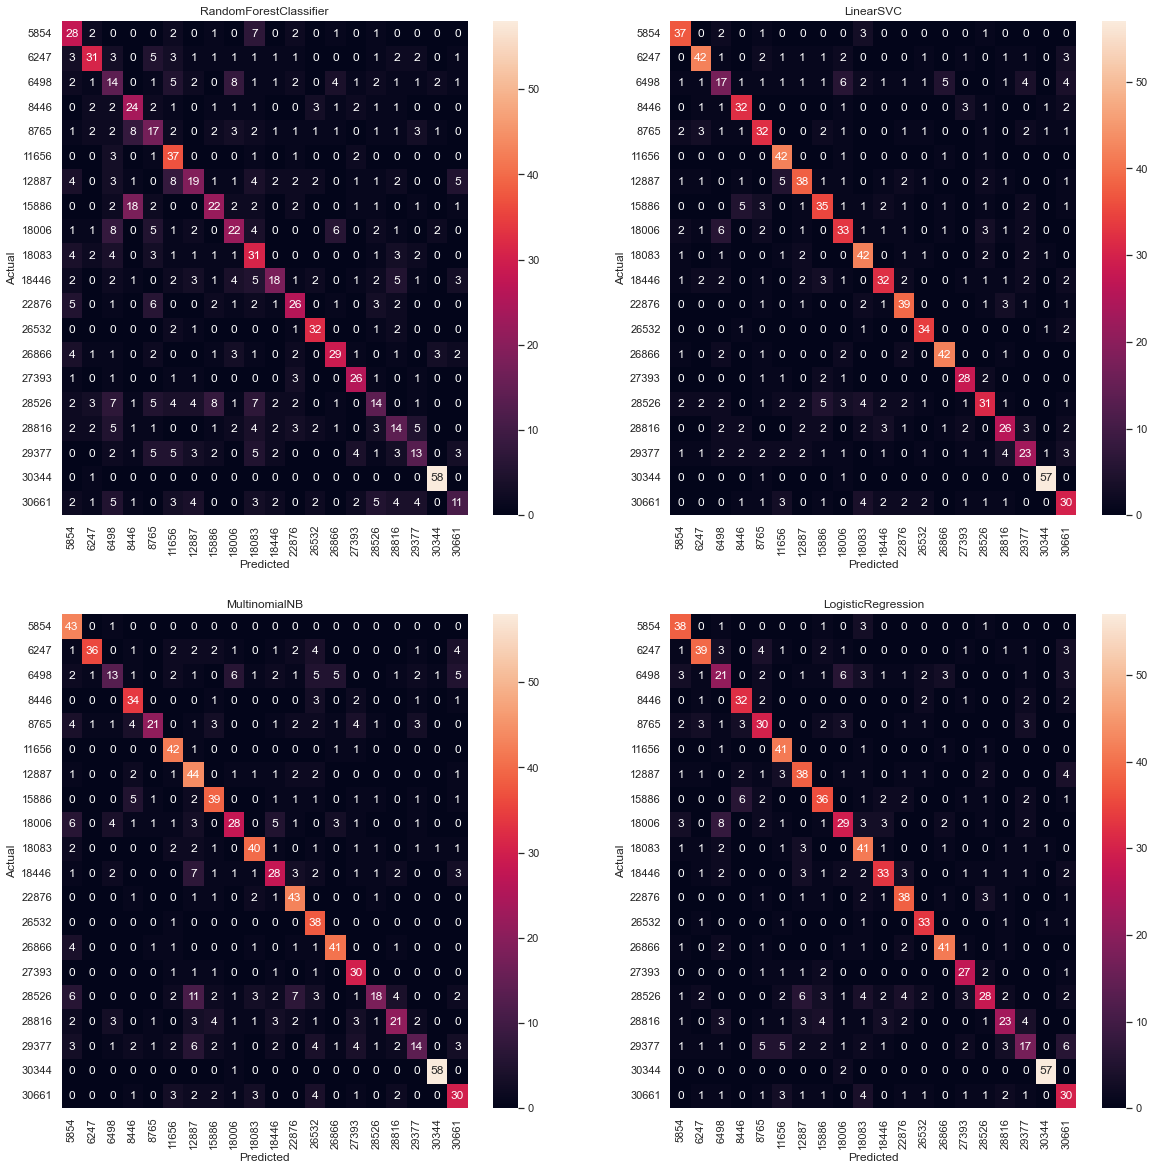

In [8]:
plt.figure(figsize=(20,20))
x = 1
for entry in entries:
    matrix = entry[1]
    plt.subplot(2,2,x)
    ax = sns.heatmap(matrix, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
    
    ax.set(title=entry[0],
      xlabel="Predicted",
      ylabel="Actual",)
    x+=1
    
sns.set(font_scale=1)